<a href="https://colab.research.google.com/github/keikekke/sound-ray-tracing/blob/master/%E9%9F%B3%E7%B7%9A%E6%B3%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 音線法のシミュレーション
音線法と呼ばれる、音の伝播についてのシミュレーションを実装する。これは、音の波動性を無視し、(大胆にも)直線でもって音の伝わり方をモデル化する、いわゆるレイトレーシングと同様の手法である。詳しい説明は以下の参考文献を参照されたい。  

参考文献: https://repository.dl.itc.u-tokyo.ac.jp/?action=repository_action_common_download&item_id=3933&item_no=1&attribute_id=14&file_no=1


## 条件設定
参考文献2.4.1章を参考に、音線数$N$, 受音球の半径$r \,\mathrm{m}$, 室体積$V \,\mathrm{m^3}$の間の関係を設定する。  

定常状態の要求について式2.5より $N \geq \frac{V}{\frac{4}{3} \pi r^3}$  
伝播距離については、式2.7式は正しくは$\frac{4\pi}{N} \left( c t_{max} \right)^2$ だと思われる(少なくとも論文の式では単位が $\mathrm{m}$と同じになってしまい、面積を表しようがない(物理で「次元」解析と呼ばれる考え方)ので、これは論文の誤りだろう。参考: https://physnotes.jp/foundations/dimensions/ )から、これを円の面積とみなすと半径は$\frac{2}{\sqrt{N}} c t_{max}$ (これが2.8式)で、式2.9の条件は $ r \geq \frac{2}{\sqrt{N}} c t_{max}$. これを$t_{max}$について解いて、$t_{max} \leq \frac{r \sqrt N} {2 c}$を得る。これが、少なくとも1本の音線が受音球と交差する条件のもと、最大の音線追跡可能時間を与える。  

## データ構造
- 境界面は平面であるとし、方程式 $ax+by+cz+d=0$のパラメータ`(a, b, c, d)`を保持する。  
- 音線は点$\vec p$を通り$\vec {dir}$に平行な(半)直線として、音速$c$およびパラメータ$t$を用いて$\vec p + c t \, \vec {dir}$で表す。`p`と`dir`を保持する。  

## アルゴリズム
音源から全方角に対して音線をつくり、各音線について以下の操作を行う。
1. 各境界平面に対して、音線との共有点の座標を求める。これは、直線が平面と交わるときのパラメータ$t$の値を調べれば良い。$\vec p = (p_x, p_y, p_z), \,\vec {dir} = (d_x, d_y, d_z)$のとき、$a(p_x+ctd_x) + b(p_y+ctd_y) + c(p_z+ctd_z) + d = 0$から$t = -\frac{ap_x+bp_y+cp_z+d}{(ad_x+bd_y+cd_z)c}$と求まる。もしこの$t$が負なら、音線の後方なので、実際には衝突していないことに留意する。
2. 1.で求めた交点のうち、最小距離のものを求める。このとき、$0$に非常に近いものは前回の衝突壁面である可能性があるので除く。残りの中から$t$が最小のものを選べば良い。
3. 音線が室の外部を通って最初の壁面に衝突していないか確認する。もしそうなら、この音線の追跡を終了し、次の音線に進む。一般に、ある点が図形の内部にある場合、その点から伸ばした半直線は図形と奇数回交差し、外部にある場合は偶数回交差する。半直線が図形の辺や面上にあるときは特殊であるが、今回は外部とみなしている。
4. 壁面衝突までに受音球を通ったか確認する。これには、受音球の中心と音線の距離を考える。音線を上のようにベクトルでパラメータ表示し、球の中心を$\vec {dest}$としたとき、時刻$t$で音線上を動く点$\vec p + c t \, \vec {dir}$と球の中心$\vec {dest}$を結ぶ線分は、その長さが最小になるとき音線の方向ベクトル$\vec {dir}$と直交する。すなわち$(\vec p + c t \, \vec {dir} - \vec {dest}) \cdot \vec {dir} = 0$. ここから$t$を求めれば、音線と球の最短距離$distance$がわかる。これが球の半径$radius$以下であれば、球の内部を通過する部分の音線の長さを三平方の定理から$2 \sqrt{radius^2-distance^2}$と求められる。これを時間に直したものが、最初の壁面までの衝突までに含まれれば、受音球を通過している。
5. 壁面衝突後の音線は、「吸収による消滅」、「鏡面反射」、「拡散反射」の3通りの可能性がある。設定された確率でそれぞれが選ばれるようにする。鏡面反射の場合、入射ベクトルを$\vec {d}$, 壁面の法線ベクトルを$\vec n$, 反射ベクトルを$\vec r$とすると、$\vec n$の向きによらず$\vec r = \vec d - 2(\vec n \cdot \vec d) \vec n$が成り立つことがわかる。この$\vec r$で$\vec d$を更新すればよい。拡散反射の場合、反射先の方向は全方位からひとつの方向を一様に選ぶ。そのアルゴリズムは https://ja.wikipedia.org/wiki/%E8%B6%85%E7%90%83%E9%9D%A2#(n_%E2%88%92_1)_%E6%AC%A1%E5%85%83%E7%90%83%E9%9D%A2%E3%81%8B%E3%82%89%E4%B8%80%E6%A7%98%E3%81%AB%E7%84%A1%E4%BD%9C%E7%82%BA%E3%81%AB にあるものを用いる(今回はn=3)。  
6. 音線追跡の原点と時刻を更新し、1.に戻る。

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import deepcopy
from tqdm import tqdm

In [2]:
def eqzero(x):
    """ ゼロに等しいか、誤差を考慮して判定する """
    return np.abs(x) < 1e-5      # 少しの誤差を許容

In [3]:
# 球面に(ほぼ)等間隔に点を分布させるアルゴリズム
# 参考: https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf

def sp(theta, phi):
    """ 単位球面座標に変換 """
    x = math.sin(theta) * math.cos(phi)
    y = math.sin(theta) * math.sin(phi)
    z = math.cos(theta)
    return (x,y,z)

def create_equidistributed_rays(N):
    """
    (およそ)N個の単位球面上の等間隔な点集合を生成する
    return: (N_created, points) where points is an nd-array of (x,y,z)s
    参考: https://www.cmu.edu/biolphys/deserno/pdf/sphere_equi.pdf
    """

    points = []
    N_created = 0
    a = 4 * math.pi * 1**2 / N      # 1 for radius
    d = math.sqrt(a)
    M_theta = round(math.pi / d)
    d_theta = math.pi / M_theta
    d_phi = a / d_theta
    for m in range(M_theta):
        theta = math.pi * (m + 0.5) / M_theta
        M_phi = round(2 * math.pi * math.sin(theta) / d_phi)
        for n in range(M_phi):
            phi = 2 * math.pi * n / M_phi
            points.append(sp(theta, phi))
            N_created += 1
    # N_created は N に近い値になるはず、とのこと
    return (N_created, np.array(points))

In [4]:
class Hall:
    def __init__(self, faces, V, alpha, c, beta=None):
        self.faces = faces  # 室の境界面たち
        self.V = V          # 室の体積 (単位: m^3)
        self.alpha = alpha  # 吸音率
        self.beta = beta if beta is not None else alpha    # 拡散反射率
        self.c = c          # 音速 (単位: m/s)

    def ray_trace(self, source, dest, radius, N=None, t_max=None, verbose=False):
        """
        音線法を実行する
        source: 音源座標 (単位: m)
        dest:   受音球座標 (単位: m)
        radius: 受音球半径 (単位: m)
        N:      音線数
        t_max:  音線追跡時間 (単位: s)

        RETURN: t_maxまでに受音球に音線が突入した回数
        """
        NN = math.ceil(self.V / (4/3 * math.pi * radius**3))
        if N is None:
            N = NN  # 音線数
        elif N < NN:
            print(f'WARNING: N should be >= 4/3 * PI * radius**2 = {NN}')

        tt_max = radius * math.sqrt(N) / (2 * self.c)
        if t_max is None:
            t_max = tt_max  # 音線追跡時間 (単位: s)
        elif t_max > tt_max:
            print(f'WARNING: t_max should be <= radius * sqrt(N) / (2 * c) = {tt_max}')

        N_created, ray_dirs = create_equidistributed_rays(N)

        if verbose:
            print(f'created {N_created} rays. simulating until after {t_max} s')

        entry_counts = np.zeros(N_created) # 各音線が受音球を通った回数
        ray_traces = [] # 各音線の軌跡. 折れ線の頂点のみ記録する
        
        for ix,dir_init in enumerate(ray_dirs):
            t = 0.0     # 時刻
            p = deepcopy(source)       # 現在の音線の先端位置
            dir = deepcopy(dir_init)   # 音線の方向ベクトル
            ray_traces.append([source])

            while t < t_max:
                # 1. 衝突時刻の計算
                t_hits = [] # 音線を無限に伸ばしたとき、各面に交差する時間
                for (a,b,c,d) in self.faces:
                    tmp = -(a*p[0] + b*p[1] + c*p[2] + d)
                    with np.errstate(divide='ignore'):
                        tmp /= (a*dir[0] + b*dir[1] + c*dir[2]) * self.c
                    t_hits.append(tmp)
                t_hits = np.array(t_hits)

                # 2. 最短衝突点の決定
                nonzero = t_hits[np.logical_not(eqzero(t_hits))]
                positive = nonzero[nonzero > 0]
                sorted = np.sort(positive)
                if sorted.size == 0:
                    break  # 音線の前方に壁面がないので、次の音線へ
                t_first_hit = sorted[0]

                #print(f'ix = {ix}, dir = {dir}, t_first = {t_first_hit}')

                
                # 3. 音線の内外判定
                if sorted.size % 2 == 0:
                    # 音線が室の外部を通ってfirst hitしている
                    break  # 次の音線へ

                # 4. 壁面衝突までに受音球を通ったか確認
                t_min = (dest- p).dot(dir) / self.c  # 受音球に最小距離となる時間
                distance = np.linalg.norm(p + self.c*t_min*dir - dest)
                if radius >= distance:
                    D = math.sqrt(radius**2 - distance**2) / self.c
                    # 区間[t_min-D, t_min+D]が[0, t_first_hit]に含まれればよい
                    if 0 <= t_min + D and t_min + D <= t_first_hit:
                        entry_counts[ix] += 1  # 受音球を通過
                    elif 0 <= t_min - D and t_min - D <= t_first_hit:
                        entry_counts[ix] += 1  # 受音球を通過

                # 5. 反射音線の決定、更新
                next_dir = np.zeros(3)                  # 次の方向
                if np.random.rand() <= self.alpha:
                    break  # 吸音されたので、次の音線へ
                if np.random.rand() <= self.beta:
                    # 反射音線は拡散反射なので、全方位からランダムに決定
                    x1, x2, x3 = np.random.normal(0, 1, 3)
                    r = np.sqrt(x1**2 + x2**2 + x3**2)
                    next_dir = np.array([x1, x2, x3]) / r
                else:
                    # 鏡面反射
                    normal = self.faces[t_hits == t_first_hit][0][0:3]   # 法線
                    normal = normal / np.linalg.norm(normal)        # 正規化
                    next_dir = dir - 2 * np.dot(normal, dir) * normal

                # 6. 音線追跡の原点、時刻の更新
                p += t_first_hit * dir * self.c       # update
                t += t_first_hit                      # update
                dir = next_dir                        # update
                ray_traces[ix].append(deepcopy(p))    # 衝突頂点を記録

        return entry_counts, ray_traces

In [5]:
# Hallインスタンス生成とシミュレーション

hall1 = Hall(
    faces = np.array([        # 室の境界面たち
          (1,0,0,0),       # 平面 1*x + 0*y + 0*z + 0 = 0 (単位: m)
          (0,1,0,0),
          (0,0,1,0),
          (1,0,0,-20),     # 平面 1*x + 0*y + 0*z -20 = 0 (単位: m)
          (0,1,0,-30),
          (0,0,1,-10),
    ]),
    V = 10*20*30,     # 室の体積 (単位: m^3)
    alpha = 0.2,      # 吸音率
    beta = 0.3,       # 拡散反射率
    c = 340,          # 音速 (単位: m/s)
)

ecounts, rtraces = hall1.ray_trace(
    source = np.array([5., 15., 2.]),   # 音源座標 (単位: m)
    dest = np.array([15., 15., 2.7]),   # 受音球座標 (単位: m)
    radius = 2,                         # 受音球半径 (単位: m)
    N=1500,
    verbose=True
)

print(f'交差数: {int(sum(ecounts))}')

created 1500 rays. simulating until after 0.11391127488845344 s
交差数: 54


In [6]:
# 今回は複数の受音球を調べる。各受音球も`n_trial`回交差数の検査をして、平均と分散を求める。

n_trial = 30                   # 各条件で試行する回数
s = np.array([5., 15., 2.])    # 音源座標 (単位: m)
r = 2                          # 受音球半径 (単位: m)
ts = np.array([                # 受音球座標たち (単位: m)
               [10., 5., 1.],
               [17., 27., 6.],
               [5., 6., 2.],
])

for t in ts:
    results = np.zeros(n_trial)
    for i in tqdm(range(n_trial), desc=f'testing on {t}'):
        results[i] = sum(hall1.ray_trace(s, t, r, N=1500)[0])
    avg = np.average(results)
    std = np.std(results)
    print(f'\n受音球座標{t}. 平均交差数: {avg}, 標準偏差: {std}')

testing on [17. 27.  6.]:   0%|          | 0/30 [00:00<?, ?it/s]


受音球座標[10.  5.  1.]. 平均交差数: 47.13333333333333, 標準偏差: 4.580635569680503


testing on [5. 6. 2.]:   0%|          | 0/30 [00:00<?, ?it/s]


受音球座標[17. 27.  6.]. 平均交差数: 44.0, 標準偏差: 5.304086474910956


testing on [5. 6. 2.]: 100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


受音球座標[5. 6. 2.]. 平均交差数: 69.0, 標準偏差: 5.686240703077327


created 4 rays. simulating until after 0.2 s
交差数: 1


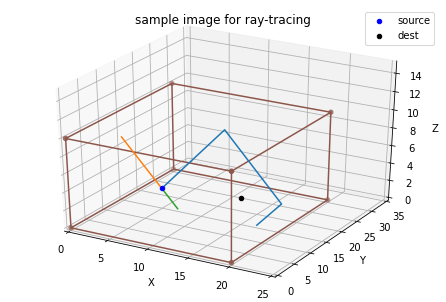

In [7]:
# 音線追跡の様子の可視化
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_box(xlen, ylen, zlen):
    fig = plt.figure()
    ax = Axes3D(fig)
    ## build 3D graph based on the above hall1 parameters
    # Draw the walls
    vertices = np.array([
                [0,0,0],
                [xlen,0,0],
                [0,ylen,0],
                [0,0,zlen],
                [xlen,ylen,0],
                [0,ylen,zlen],
                [xlen,0,zlen],
                [xlen,ylen,zlen]
    ])
    x = np.ones(2)
    y = np.array([0, 1])
    ax.scatter3D(vertices[:,0], vertices[:,1], vertices[:,2], color='tab:brown')
    ax.plot(0*x, ylen*y, 0*x, color='tab:brown')
    ax.plot(0*x, ylen*y, zlen*x, color='tab:brown')
    ax.plot(0*x, ylen*x, zlen*y, color='tab:brown')
    ax.plot(0*x, 0*x, zlen*y, color='tab:brown')
    ax.plot(xlen*y, 0*x, 0*x, color='tab:brown')
    ax.plot(xlen*y, 0*x, zlen*x, color='tab:brown')
    ax.plot(xlen*x, 0*x, zlen*y, color='tab:brown')
    ax.plot(xlen*x, ylen*x, zlen*y, color='tab:brown')
    ax.plot(xlen*x, ylen*y, zlen*x, color='tab:brown')
    ax.plot(xlen*x, ylen*y, 0*x, color='tab:brown')
    ax.plot(xlen*y, ylen*x, 0*x, color='tab:brown')
    ax.plot(xlen*y, ylen*x, zlen*x, color='tab:brown')

    ax.set_xlim(0, 25)
    ax.set_ylim(0, 35)
    ax.set_zlim(0, 15)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    return ax

ax = draw_box(20, 30, 10)

source = np.array([5., 15., 2.])   # 音源座標 (単位: m)
dest = np.array([15., 15., 2.7])   # 受音球座標 (単位: m)

ecounts, rtraces = hall1.ray_trace(
    source=source,   # 音源座標 (単位: m)
    dest=dest,       # 受音球座標 (単位: m)
    radius=2,        # 受音球半径 (単位: m)
    N=3,
    t_max=0.2,
    verbose=True
)

for trace in rtraces:
    x = [point[0] for point in trace]
    y = [point[1] for point in trace]
    z = [point[2] for point in trace]
    ax.plot(x, y, z)

ax.scatter3D(source[0], source[1], source[2], color='blue', label='source')
ax.scatter3D(dest[0], dest[1], dest[2], color='black', label='dest')

print(f'交差数: {int(sum(ecounts))}')

plt.title('sample image for ray-tracing')
plt.legend()
plt.show()